In [9]:
from google.colab import files
import pandas as pd
import io
import time
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [1]:
uploaded = files.upload()

Saving preprocessed_data.csv to preprocessed_data.csv


In [5]:
data_ready = pd.read_csv(io.BytesIO(uploaded['preprocessed_data.csv']))

In [ ]:
#%store -r data_ready

In [6]:
#print(data_ready['category'].value_counts())
cat_index = data_ready['category'].value_counts().index

In [ ]:
def create_lr_model():
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 10000)
    return model

Set 0

In [28]:
select_data = data_ready[data_ready['category'].isin(cat_index[1:4])].dropna().reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"],
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

X_train.sort_indices()
X_test.sort_indices()

quant-ph    44678
hep-th      39013
gr-qc       25712
Name: category, dtype: int64


Tune regularization for multinomial logistic regression

In [44]:
model = create_lr_model()

# define the grid search parameters
cand_pt = ['none', 'l2']
cand_rs = [0.0001, 0.001, 0.01, 0.1, 1.0]
#cand_mi = [10, 100, 1000, 10000][1:2]

param_grid0 = dict(penalty=cand_pt[1:2], C=cand_rs)
param_grid1 = dict(penalty=cand_pt[0:1])

grid0 = GridSearchCV(estimator=model, param_grid=param_grid0, n_jobs=-1, cv=5)
grid1 = GridSearchCV(estimator=model, param_grid=param_grid1, n_jobs=-1, cv=5)

In [45]:
s = time.time()
grid_results_l2 = grid0.fit(X_train, y_train)
f = time.time()
el_t = f-s

cv_results_l2 = pd.DataFrame.from_dict(grid_results_l2.cv_results_)

print("Best accuracy with l2 regularization: %f using %s" % (grid_results_l2.best_score_, grid_results_l2.best_params_))
print("\n")
print("Time needed for the estimation: %f" % (el_t))

Best accuracy with l2 regularization: 0.914547 using {'C': 1.0, 'penalty': 'l2'}


Time needed for the estimation: 207.899354


In [42]:
s = time.time()
grid_results_noreg = grid1.fit(X_train, y_train)
f = time.time()
el_t = f-s

cv_results_noreg = pd.DataFrame.from_dict(grid_results_noreg.cv_results_)

print("Best accuracy without regularization: %f using %s" % (grid_results_noreg.best_score_, grid_results_noreg.best_params_))
print("\n")
print("Time needed for the estimation: %f" % (el_t))

Best accuracy without regularization: 0.869644 using {'penalty': 'none'}


Time needed for fitting: 1207.583550


In [51]:
cv_results = pd.concat([cv_results_l2, cv_results_noreg]).reset_index(drop=True)
cv_results = cv_results.sort_values(by=['mean_test_score'], ascending=False)
cv_results_set0_lr = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score', 'rank_test_score'], 1)
cv_results_set0_lr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,mean_fit_time,mean_score_time,param_C,param_penalty,mean_test_score,std_test_score
4,30.513894,0.044170,1.0,l2,0.914547,0.002917
3,14.951698,0.052303,0.1,l2,0.900802,0.002861
5,187.934037,0.043555,NaN,none,0.869644,0.002257
2,9.739502,0.059165,0.01,l2,0.866079,0.002371
1,4.003841,0.049568,0.001,l2,0.702578,0.001685
0,2.941028,0.068071,0.0001,l2,0.408412,0.000030


In [52]:
%store cv_results_set0_lr

Stored 'cv_results_set0_lr' (DataFrame)


In [53]:
#from google.colab import files

cv_results_set0_lr.to_csv('cv_results_set0_lr.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set0_lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#MULTINOMIAL LOGISTIC REGRESSION with tuned hyperparameters

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1, max_iter = 1000)

# make a prediction with a multinomial logistic regression model
# fit the model on the whole dataset
model.fit(X_train, y_train)
# define a single row of input data
yhat = model.predict(X_test)

#Accuracy score
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % round(acc, 3))
print('\n')
#Confusion matrix
conf = confusion_matrix(y_test, yhat)
print('Confusion matrix:\n', conf)

Accuracy: 0.951


Confusion matrix:
 [[9563  460   98]
 [ 349 7256  197]
 [  40  165 8731]]


Set 1

In [ ]:
select_data = data_ready[data_ready['category'].isin(cat_index[4:9])].reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"],
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

stat       19868
math-ph    17597
nucl-th    13730
q-bio      13316
hep-ex     10158
Name: category, dtype: int64


In [ ]:
# define the grid search parameters
cand_pt = ['none', 'l2']
cand_rs = [0.0001, 0.001, 0.01, 0.1, 1.0][4:]
cand_mi = [10, 100, 1000, 10000][1:2]

param_grid0 = dict(penalty=cand_pt[1:2], C=cand_rs, max_iter=cand_mi)
param_grid1 = dict(penalty=cand_pt[0:1], max_iter=cand_mi)

grid0 = GridSearchCV(estimator=model, param_grid=param_grid0, n_jobs=-1, cv=5)
grid1 = GridSearchCV(estimator=model, param_grid=param_grid1, n_jobs=-1, cv=5)

In [ ]:
grid_result0 = grid0.fit(X_train, y_train)
cv_results0 = pd.DataFrame.from_dict(grid_result0.cv_results_)
grid_result1 = grid1.fit(X_train, y_train)
cv_results1 = pd.DataFrame.from_dict(grid_result1.cv_results_)

# summarize results
print("Best with regularization: %f using %s" % (grid_result0.best_score_, grid_result0.best_params_))
print("Best without regularization: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))

cv_results = pd.concat([cv_results0, cv_results1]).reset_index(drop=True)
cv_results = cv_results.sort_values(by=['mean_test_score'], ascending=False)
cv_results_set1 = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score', 'rank_test_score'], 1)
%store cv_results_set1
cv_results_set1

C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best with regularization: 0.951519 using {'C': 1.0, 'max_iter': 100, 'penalty': 'l2'}
Best without regularization: 0.943768 using {'max_iter': 100, 'penalty': 'none'}
Stored 'cv_results_set1' (DataFrame)


C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,mean_fit_time,mean_score_time,param_C,param_max_iter,param_penalty,mean_test_score,std_test_score
0,29.839002,0.031245,1.0,100,l2,0.951519,0.002004
1,28.308878,0.031253,NaN,100,none,0.943768,0.001902


In [ ]:
#MULTINOMIAL LOGISTIC REGRESSION with tuned hyperparameters

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1, max_iter = 1000)

# make a prediction with a multinomial logistic regression model
# fit the model on the whole dataset
model.fit(X_train, y_train)
# define a single row of input data
yhat = model.predict(X_test)

#Accuracy score
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % round(acc, 3))
print('\n')
#Confusion matrix
conf = confusion_matrix(y_test, yhat)
print('Confusion matrix:\n', conf)

Accuracy: 0.952


Confusion matrix:
 [[1972    3   47    3    7]
 [   2 3442   16   29   30]
 [  35   68 2632    6    5]
 [   0   53    4 2397  209]
 [   2   45    0  151 3776]]


Extra

In [ ]:
#MULTINOMIAL LOGISTIC REGRESSION with tuned hyperparameters

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1)

# make a prediction with a multinomial logistic regression model
# fit the model on the whole dataset
model.fit(X_train_tfidf, y_train)
# define a single row of input data
yhat = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, yhat)
conf = confusion_matrix(y_test, yhat)

#Accuracy score
print('Accuracy: %.3f' % round(acc, 3))

print('\n')

#Confusion matrix
print('Confusion matrix:\n', conf)

Predicted Class: hep-ph
Predicted Probabilities: [0.9962049  0.00222638 0.00156872]
Real Class: hep-ph


C:\Users\Matteo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#For observation 0
# summarize the predicted class
print('Predicted Class: %s' % yhat[0])

# predict a multinomial probability distribution
yhat_p = model.predict_proba(X_test_tfidf)
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhat_p[0])

print('Real Class: %s' % y_test[0])

Predicted Class: hep-ph
Predicted Probabilities: [0.9962049  0.00222638 0.00156872]
Real Class: hep-ph


0.0000
>0.0000 0.942 (0.001)
0.0001
>0.0001 0.386 (0.000)
0.0010
>0.0010 0.873 (0.003)
0.0100
>0.0100 0.930 (0.001)
0.1000
>0.1000 0.942 (0.001)
1.0000
>1.0000 0.951 (0.001)


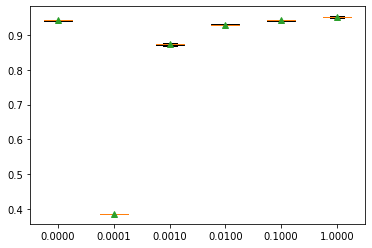

In [ ]:
for name, model in models.items():
    print(name)
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize progress along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()